In [1]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
%matplotlib inline

In [2]:
# code for visualisation of each function
from graphviz import Digraph
def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for children in v._prev:
                edges.add((children, v))
                build(children)
    build(root)
    return nodes, edges


# def draw_dot(root):
#     dot = Digraph(format = 'svg', graph_attr = {'rankdir': "BT"}) # LR = left to right
#     nodes, edges = trace(root)

#     for n in nodes:
#         uid = str(id(n)) # Return the identity of an object. This is guaranteed to be unique among simultaneously existing objects. (CPython uses the object's memory address.)
#         # for any value in the graph, create a rectangular ('record') node for it
#         dot.node(name = uid, label = "{ %s | data %.4f | gradient %.10f}" % (n.label, n.data, n.grad), 
#                  shape='record',  style='filled', fillcolor='#F0F8FF')
#         if n._op:
#             # If this value is a result of some operations, create an _op node for it
#             dot.node(name = uid + n._op, label = n._op)
#             # and connect this node to it
#             dot.edge(uid + n._op, uid)
    
#     for n1, n2 in edges:
#         # connect n1 to the op node of n2
#         dot.edge(str(id(n1)), str(id(n2)) + n2._op)

#     dot.attr(label=r'Forward Pass')
#     dot.attr(fontsize='12')
                 
#     return dot

from graphviz import Digraph

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'BT', 'splines': 'true', 'nodesep': '0.8', 'ranksep': '0.5'})

    nodes, edges = trace(root)

    # Group nodes by operations
    op_nodes = set(n for n in nodes if n._op)
    for n in nodes:
        uid = str(id(n))
        if n._op:
            # Create a node for the operation
            dot.node(name=uid + n._op, label=n._op, shape='ellipse', style='filled', fillcolor='#E0E0E0')

    for n in nodes:
        uid = str(id(n))
        label = "{ %s | data %.4f | gradient %.10f}" % (n.label, n.data, n.grad)
        # Create a rectangular ('record') node for each value
        dot.node(name=uid, label=label, shape='record', style='filled', fillcolor='#F0F8FF')

        if n._op:
            # Connect the value node to its operation node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect nodes based on the edges
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    dot.attr(label=r'Forward Pass')
    dot.attr(fontsize='10')  # Adjust font size for better readability

    return dot


In [3]:
class Variable:
    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        self._backward = lambda: None # this is responsible for the chain-rule value - a function that by default does nothing
        
    def __add__(self, other):
        """
        To add two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * output.grad # This will mimic the chain rule, output gradient is the gradient that is coming from the future nodes, e.g: df/dx = df/dy * dy/dx
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data * other.data, _children=(self, other), _op = '*')
        
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
            
        output._backward = _backward
        return output

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        output = Variable(self.data ** other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * output.grad
            
        output._backward = _backward
        return output            
            

    def exp(self):
        x = self.data
        output = Variable(math.exp(x), _children=(self, ), _op='exp')

        def _backward():
            self.grad += output.grad * output.data
            
        output._backward = _backward
        return output
            

    def backward(self):
        self.topological_graph = []
        visited_nodes = set()
        
        def build_topological_graph(v):
            if v not in visited_nodes:
                visited_nodes.add(v)
                for child in v._prev:
                    build_topological_graph(child)
                self.topological_graph.append(v)
        
        build_topological_graph(self)

        self.grad = 1.0
        """
        We want to start from the last node in the topological graph and pass the gradient backward. last node (n) by default has 
        gradient of 1. then the n-1 node has gradient of 1 * gradient of node (n-1)
        """
        for node in reversed(self.topological_graph): 
            node._backward()

    def __draw__(self):
        return draw_dot(self)
                
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __truediv__(self, other):
        """
        Return a / b where 2/3 is .66 rather than 0. This is also known as “true” division.
        """
        return self * other**-1

    def __neg__(self):
        """
        Return obj negated (-obj).
        """
        return self * -1

    def __rsub__(self, other):
        """
         __rsub__() method implements the reverse subtraction operation that is subtraction with reflected,
         swapped operands. # other - self
        """
        return other - self

    def __radd__(self, other): # other + self
        return self + other

    def __rtruediv__(self, other): # other / self
        """
        The Python __rtruediv__() method implements the reverse true division operation with reflected, 
        swapped operands. So, when you call other / self,
        """
        return other * self**-1

    def __rmul__(self, other):
        """
        Python can not multiply other * self if other is simply a digit. Ex: 2 * Variable(4)
        so we define __rmul__ which by default will run if __mul__ operation was not possible. 
        """
        return self * other


In [4]:
class Activations(Variable):
    def sigmoid(self):
        n = self.data
        t = 1/(1 + math.exp(-n))
        output = Variable(t, _children=(self, ), _op = 'sigmoid')

        def _backward():
            self.grad += t * (1 - t) * output.grad

        output._backward = _backward        
        return output

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')

        def _backward():
            self.grad += (1 - t**2) * output.grad

        output._backward = _backward        
        return output

    def relu(self):
        """
        The product of gradients of ReLU function doesn't end up converging to 0 as the value is either 0 or 1.
        If the value is 1, the gradient is back propagated as it is. If it is 0, then no gradient is backpropagated from that point backwards.
        """
        n = self.data
        t = n if n > 0 else 0
        output = Variable(t, _children=(self, ), _op = 'relu')

        def _backward():
            if t > 0:
                self.grad += 1 * output.grad
            else:
                self.grad += 0 * output.grad

        output._backward = _backward        
        return output

    def leaky_relu(self):
        """
        """
        n = self.data
        t = n if n > 0 else 0.01*n
        output = Variable(t, _children=(self, ), _op = 'leaky relu')

        def _backward():
            if t > 0:
                self.grad += 1 * output.grad
            else:
                self.grad += 0.01 * output.grad

        output._backward = _backward        
        return output        

    # @staticmethod
    # def softmax(self, xs):
    #     datas = [x.data for x in xs]
    #     e_x = [np.exp(a - max(datas)) for a in [self.data] + datas]
    #     smx = e_x[0] / sum(e_x)
    #     output = Variable(smx, _children=(self, ), _op = 'softmax')

        # def _backward():
        #     if  > 0:
        #         self.grad += 1 * output.grad
        #     else:
        #         self.grad += 0.01 * output.grad
                
        # output._backward = _backward        
        # return output    

In [5]:
# import numpy as np

# def softmax(x):
#     e_x = np.exp(x - np.max(x))
#     return e_x / np.sum(e_x)

# def softmax_derivative(x):
#     s = softmax(x)
#     d = np.diag(s) - np.outer(s, s)
#     return d

# # Example usage:
# x = np.array([1.0, 2.0, 3.0])
# softmax_derivative_x = softmax_derivative(x)

# print("Input x:", x)
# print("Softmax derivative:", softmax_derivative_x)

In [ ]:
# x1 = Variable(2., label = 'x1') # input 1 
# x2 = Variable(0., label = 'x2') # input 2
# w1 = Variable(-3., label = 'w1') # weight 1
# w2 = Variable(1., label = 'w2') # weight 2
# b = Variable(6.8813, label = 'b') # bias

# x1w1 = x1*w1; x1w1.label = 'x1*w1'
# x2w2 = x2*w2; x2w2.label = 'x2*w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
# sig1 = Activations.leaky_relu(x1w1x2w2); sig1.label = 'sig1'
# sig2 = Activations.leaky_relu(x2w2); sig2.label = 'sig2'
# n = sig1 + b; n.label = 'n' # raw input to a neuron without activation
# o = Activations.tanh(n)

In [ ]:
# o.__draw__()

In [ ]:
# act = getattr(Activations, 'tanh')

In [ ]:
# o.backward()
# o.__draw__()

In [365]:
class Neuron:
    def __init__(self, input_d, layer_index, node_index, activation = 'linear'):
        """
        @input_d: int, number of inputs to a given neuron
        """
        self.w = [Variable(random.uniform(-1, 1), label=f"Layer{layer_index}_node{node_index}_W{_}") for _ in range(input_d)]
        self.b = Variable(random.uniform(-1, 1), label=f"Layer{layer_index}_node{node_index}_b")
        self.activation = activation

    def __call__(self, x):
        """
        f(x) python will use __call__. 
        @x: list, input
        """
        act = sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b)
        activation_function = getattr(Activations, self.activation)
        output = activation_function(act) if self.activation != 'linear' else act
        return output

    def parameters(self):
        parameters = self.w + [self.b]
        return {x.label:x for x in parameters}

    def __repr__(self):
        return f"{self.activation} Neuron({len(self.w)})"

class Layer:
    def __init__(self, neuron_dim, layer_dim, layer_index, activation = 'linear'):
        self.neurons = [Neuron(neuron_dim, activation=activation, layer_index=layer_index, node_index=_) for _ in range(layer_dim)]
        
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        params = {parameter:parameter_value for neuron in self.neurons for parameter, parameter_value in neuron.parameters().items()}
        return params

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:
    def __init__(self, input_dim, layers_dim, activation = 'linear'):
        sizes = [input_dim] + layers_dim
        self.layers = {"layer_{}".format(i+1):Layer(sizes[i], sizes[i+1], layer_index=i+1, activation=activation) for i in range(len(layers_dim))}
        
    def __call__(self,x):
        for layer in self.layers:
            x = self.layers[layer](x) # Forward pass
        return x

    def parameters(self):
        return {parameter:parameter_value for key, layer in self.layers.items() for parameter, parameter_value in layer.parameters().items()}


    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for key, layer in self.layers.items())}]"

    def __draw__(self, x):
        return draw_dot(self.__call__(x))


In [366]:
# initialize a model 
model = MLP(3, [3, 3, 1], 'tanh') # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh Neuron(3), tanh Neuron(3), tanh Neuron(3)], Layer of [tanh Neuron(3), tanh Neuron(3), tanh Neuron(3)], Layer of [tanh Neuron(3)]]
number of parameters 28


In [367]:
model.layers['layer_1'].neurons[0].w

[Variable(data=0.8590929341863249),
 Variable(data=0.01817569208682035),
 Variable(data=-0.5275801636075406)]

In [320]:
X = [2, 3, -1]
model(X)

Variable(data=0.985591994036868)

In [321]:
# model.__draw__(X) # Too large

In [411]:
np.random.seed(42)
X = np.random.randn(10000, 3)
y = np.random.randn(10000, 1) * 2  # Linear relation with some noise

In [412]:

"""

Batch Gradient Descent:

Forward Pass: Compute the loss for each data point and sum them up.
Backward Pass: Calculate the gradients with respect to the parameters using the summed-up loss.
This is often used when the dataset is not too large, and you can afford to process the entire dataset in each iteration.

Stochastic Gradient Descent (SGD):

Forward Pass: Compute the loss for each data point individually.
Backward Pass: Calculate the gradients with respect to the parameters using the loss for each individual data point.
Update the parameters after each data point.
This is beneficial when the dataset is large, as it allows for more frequent updates.

Mini-Batch Gradient Descent:

Forward Pass: Divide the dataset into mini-batches and compute the loss for each mini-batch.
Backward Pass: Calculate the gradients with respect to the parameters using the loss for each mini-batch.
Update the parameters after each mini-batch.
This is a compromise between batch and stochastic gradient descent, offering a balance between efficiency and computation.

"""
print(__doc__)



Batch Gradient Descent:

Forward Pass: Compute the loss for each data point and sum them up.
Backward Pass: Calculate the gradients with respect to the parameters using the summed-up loss.
This is often used when the dataset is not too large, and you can afford to process the entire dataset in each iteration.

Stochastic Gradient Descent (SGD):

Forward Pass: Compute the loss for each data point individually.
Backward Pass: Calculate the gradients with respect to the parameters using the loss for each individual data point.
Update the parameters after each data point.
This is beneficial when the dataset is large, as it allows for more frequent updates.

Mini-Batch Gradient Descent:

Forward Pass: Divide the dataset into mini-batches and compute the loss for each mini-batch.
Backward Pass: Calculate the gradients with respect to the parameters using the loss for each mini-batch.
Update the parameters after each mini-batch.
This is a compromise between batch and stochastic gradient des

In [420]:
class Neuron:
    def __init__(self, input_d, layer_index, node_index, activation = 'linear'):
        """
        @input_d: int, number of inputs to a given neuron
        """
        self.w = [Variable(random.uniform(-1, 1), label=f"Layer{layer_index}_node{node_index}_W{_}") for _ in range(input_d)]
        self.b = Variable(random.uniform(-1, 1), label=f"Layer{layer_index}_node{node_index}_b")
        self.activation = activation

    def __call__(self, x):
        """
        f(x) python will use __call__. 
        @x: list, input
        """
        act = sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b)
        activation_function = getattr(Activations, self.activation)
        output = activation_function(act) if self.activation != 'linear' else act
        return output

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{self.activation} Neuron({len(self.w)})"

class Layer:
    def __init__(self, neuron_dim, layer_dim, layer_index, activation = 'linear'):
        self.neurons = [Neuron(neuron_dim, activation=activation, layer_index=layer_index, node_index=_) for _ in range(layer_dim)]
        
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        params = [parameter for neuron in self.neurons for parameter in neuron.parameters()]
        return params

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:
    def __init__(self, input_dim, layers_dim, activation = 'linear'):
        sizes = [input_dim] + layers_dim
        self.layers = {"layer_{}".format(i+1):Layer(sizes[i], sizes[i+1], layer_index=i+1, activation=activation) for i in range(len(layers_dim))}
        
    def __call__(self,x):
        for layer in self.layers:
            x = self.layers[layer](x) # Forward pass
        return x

    def parameters(self):
        return [parameter for key, layer in self.layers.items() for parameter in layer.parameters()]


    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for key, layer in self.layers.items())}]"

    def __draw__(self, x):
        return draw_dot(self.__call__(x))

# initialize a model 
model = MLP(3, [3, 3, 1], 'tanh') # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters())) 

MLP of [Layer of [tanh Neuron(3), tanh Neuron(3), tanh Neuron(3)], Layer of [tanh Neuron(3), tanh Neuron(3), tanh Neuron(3)], Layer of [tanh Neuron(3)]]
number of parameters 28


In [421]:
model.parameters()

[Variable(data=0.3233282866228133),
 Variable(data=-0.5473157245753004),
 Variable(data=0.9037292014259617),
 Variable(data=-0.16008288270596416),
 Variable(data=-0.5598497196496106),
 Variable(data=-0.15351276120533885),
 Variable(data=-0.2309947525314031),
 Variable(data=-0.5941452508231095),
 Variable(data=-0.27191157344012096),
 Variable(data=0.47454705316857115),
 Variable(data=-0.9040323841520326),
 Variable(data=-0.9307256078707111),
 Variable(data=-0.6686707733694819),
 Variable(data=-0.9129127718506884),
 Variable(data=-0.16994646794363621),
 Variable(data=0.4499895554094089),
 Variable(data=0.11107229695107934),
 Variable(data=0.18750858834576167),
 Variable(data=0.6105957302250453),
 Variable(data=-0.06086258443257653),
 Variable(data=-0.7479258875009744),
 Variable(data=-0.25499048894725007),
 Variable(data=0.7867215177575964),
 Variable(data=0.35734905215870616),
 Variable(data=0.521438346422284),
 Variable(data=-0.8408484682188149),
 Variable(data=0.578909964181727),
 Var

## SGD

In [429]:
for t in range(10):
    batch_size = 64
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
        
    # OPtional - To convet input data to Variable
    inputs = [list(map(Variable, xrow)) for xrow in Xb]
    
    # Forward pass - SGD
    y_preds = list(map(model, inputs))
    losses = [(y_hat - y_)**2 for y_hat, y_ in zip(y_preds, yb)]
       
    gradients = {parameter.label:[] for parameter in model.parameters()}
    for k, loss in enumerate(losses):
        for parameter in model.parameters():
            parameter.grad = 0.0
        loss.backward()
        for parameter in model.parameters():
            gradients[parameter.label].append(parameter.grad[0]) 
            
    # Update
    for p in model.parameters():
        p.data += -0.005 * np.mean(gradients[p.label])


In [430]:
model.parameters()

[Variable(data=0.3238657423686982),
 Variable(data=-0.532270277712309),
 Variable(data=0.8920654517083537),
 Variable(data=0.0021493596737626845),
 Variable(data=-0.6117499846194079),
 Variable(data=-0.15709426080790598),
 Variable(data=-0.2583945184873497),
 Variable(data=-0.48270249555482087),
 Variable(data=-0.2787724715290672),
 Variable(data=0.4927814712387608),
 Variable(data=-0.9337541521535466),
 Variable(data=-0.9081509089152549),
 Variable(data=-0.6566773634666982),
 Variable(data=-0.8939419655568229),
 Variable(data=-0.13063484742405765),
 Variable(data=0.35847400754327263),
 Variable(data=-0.03585614010552455),
 Variable(data=0.04832934397391553),
 Variable(data=0.516589641971966),
 Variable(data=0.30153792817353825),
 Variable(data=-0.6986019079292025),
 Variable(data=-0.1709941466550092),
 Variable(data=0.8849382343416299),
 Variable(data=0.1519905675985191),
 Variable(data=0.12855059708178393),
 Variable(data=-0.7924186068131619),
 Variable(data=0.4461076763584643),
 Var

## Batch GD

In [363]:
# initialize a model 
model = MLP(3, [3, 3, 1], 'tanh') # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))    
    
for t in range(100):
    batch_size = None
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    # Forward pass
    ypreds = [model(x) for x in Xb]
    loss = sum(((ypred - y)**2  for ypred, y in zip(ypreds, yb)), Variable(0))
    
    # backward pass
    for p in model.parameters():
        p.grad = 0.0
    loss.backward()

    # Update
    for p in model.parameters():
        p.data += -0.0005 * p.grad

    print(t, loss.data)
    print(model.parameters())

In [364]:
# model.__draw__(Xb[0])

In [347]:
for parameter_key in gradients.keys():
    model.parameters()[parameter_key].data = model.parameters()[parameter_key].data - 0.001 * gradients[parameter_key]

In [23]:
# L2 regularization
alpha = 1e-4
reg_loss = alpha * sum((p*p for p in model.parameters()))
total_loss = data_loss + reg_loss

# also get accuracy
accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]

In [47]:
gradients

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [36]:
2 * (-0.3698 + 1.6580)

2.5763999999999996

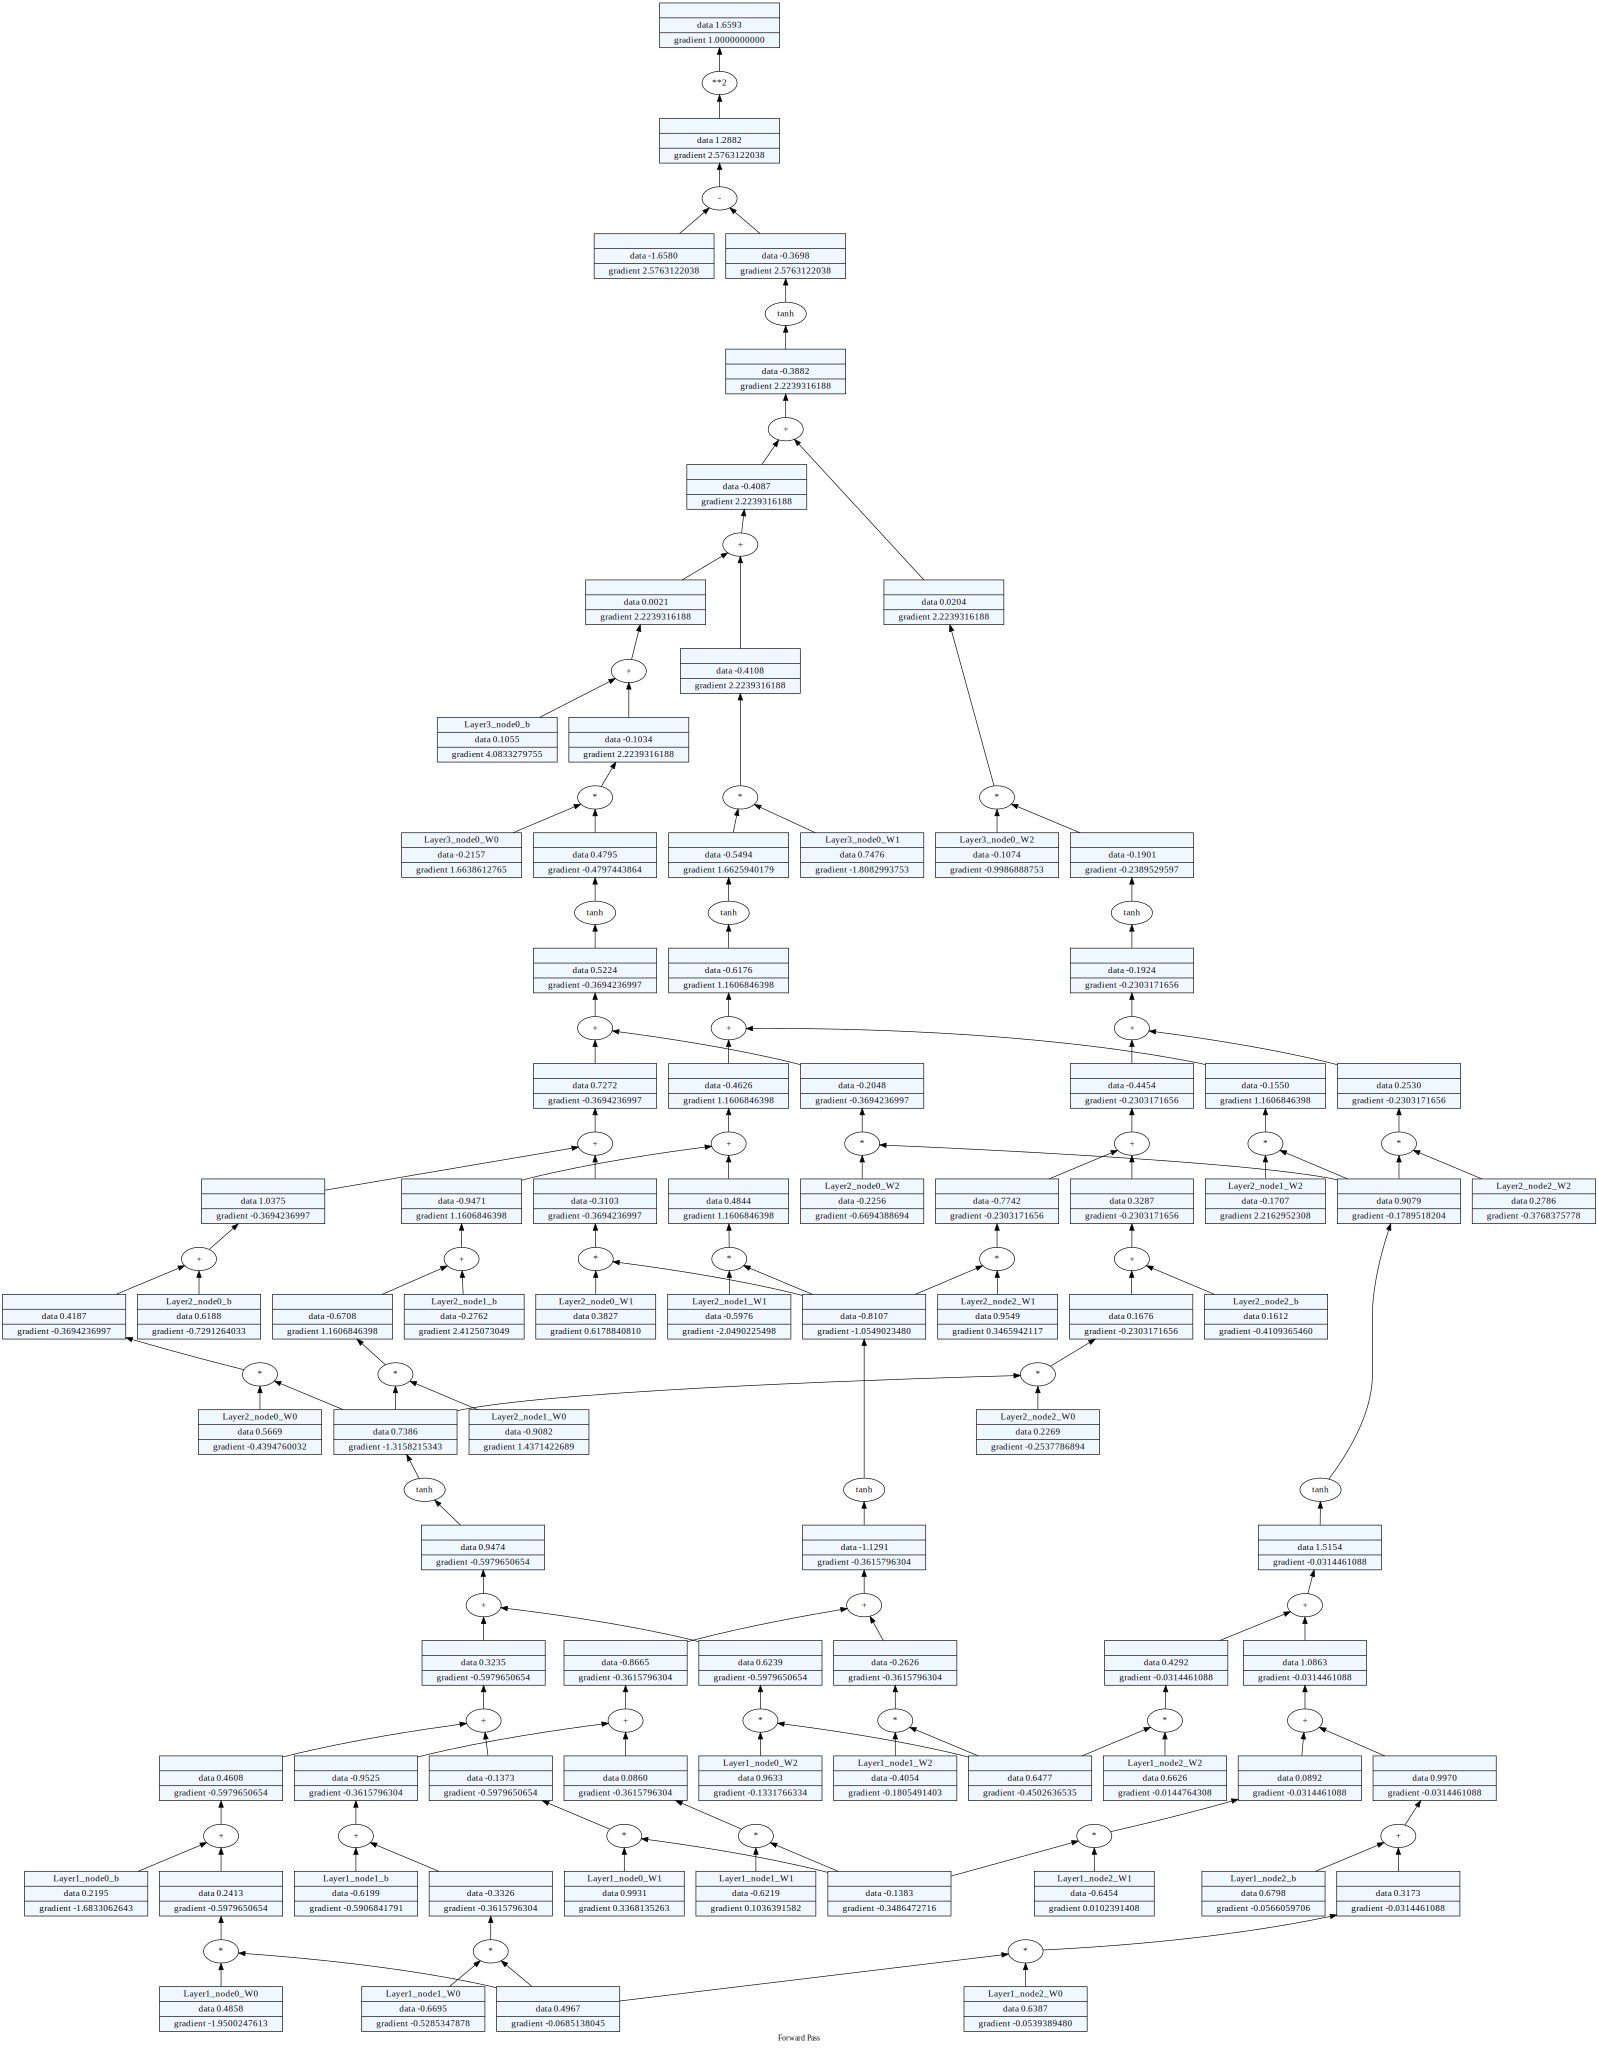

In [39]:
losses[0].__draw__()

In [92]:
model.layers['layer_1'].neurons[0].w

[Variable(data=0.6622492344267445),
 Variable(data=-0.21699784878577222),
 Variable(data=-0.8518377597599882)]

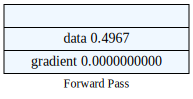

In [98]:
inputs[0][0].__draw__()

In [117]:
activation_function(model.layers['layer_1'].neurons[0].w[0] * inputs[0][0] + model.layers['layer_1'].neurons[0].w[1] * inputs[0][1] + model.layers['layer_1'].neurons[0].w[2] * inputs[0][2] + model.layers['layer_1'].neurons[0].b)

Variable(data=0.6414140830709376)

In [115]:
activation_function = getattr(Activations,'tanh')

In [119]:
scores[-1]

Variable(data=0.5716440599960607)

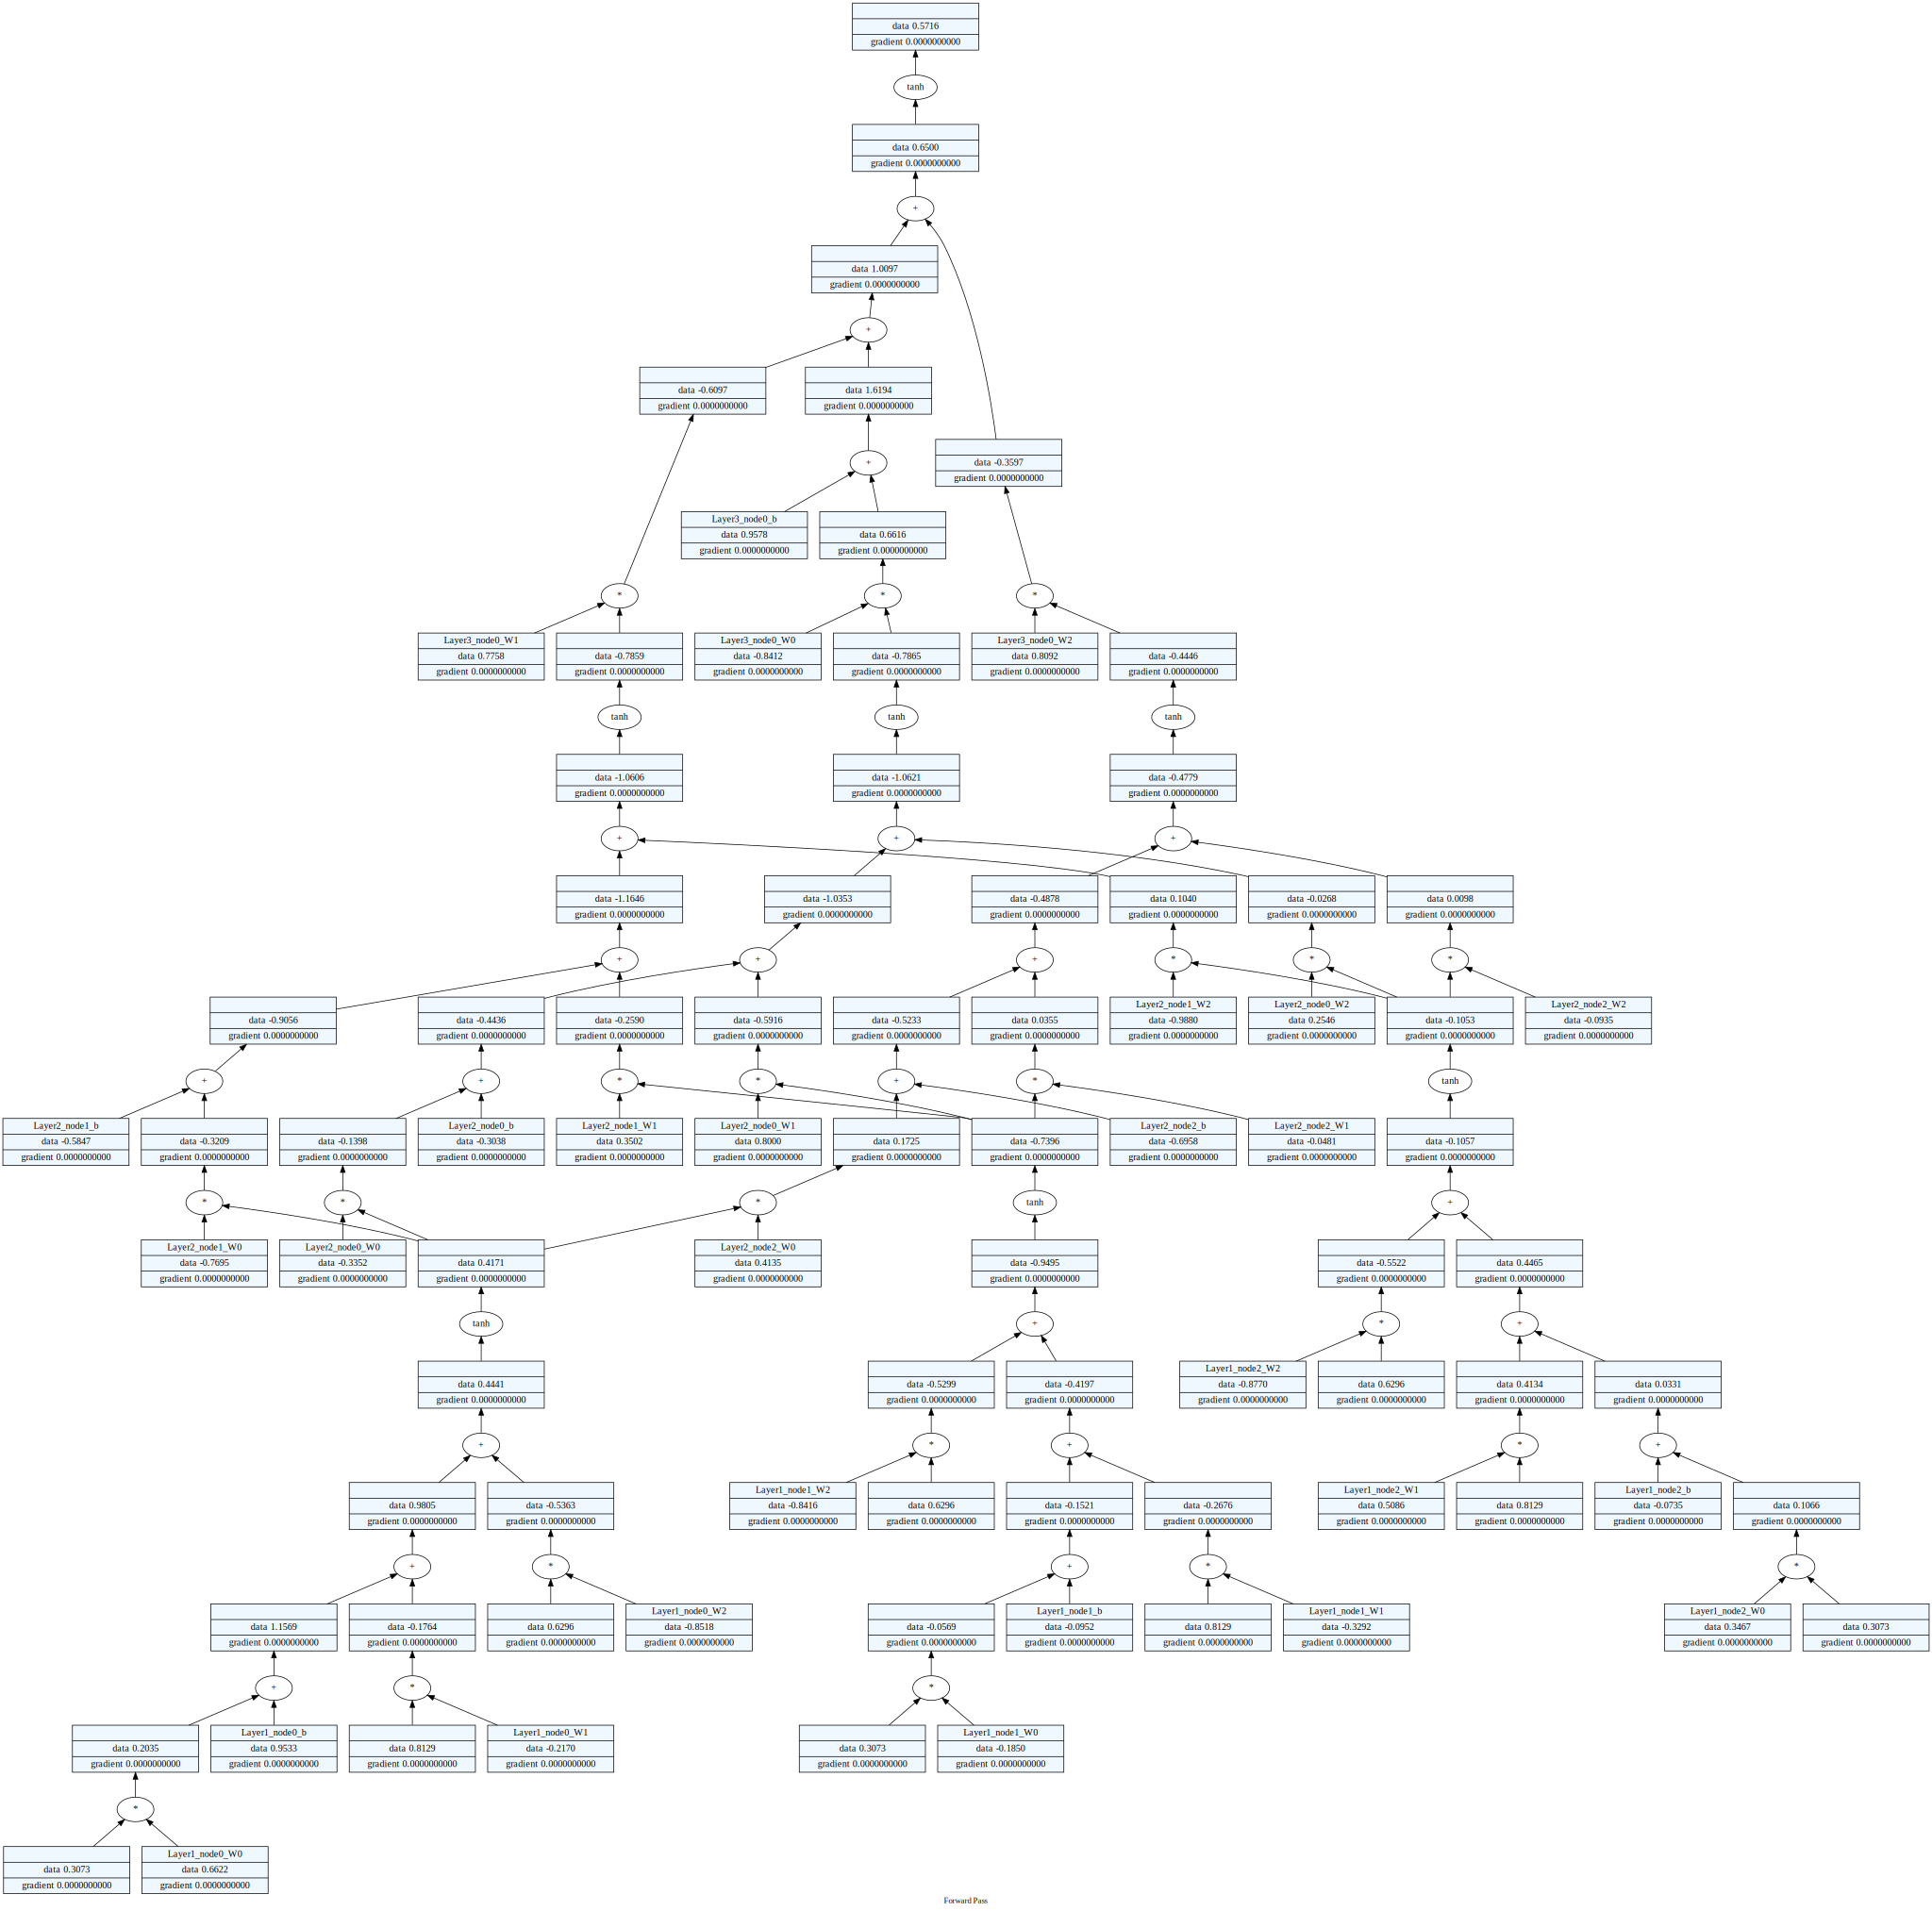

In [118]:
model.__draw__(xrow) # Too large

In [ ]:
# optimization
for k in range(50):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.grad = 0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    
    # visualize decision boundary
    
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Variable, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

### Linear Regression

In [9]:
# loss function
# def loss(batch_size=None):
batch_size = None
# inline DataLoader :)
if batch_size is None:
    Xb, yb = X, y
else:
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[ri], y[ri]
inputs = [list(map(Variable, xrow)) for xrow in Xb]
# forward the model to get scores
scores = list(map(model, inputs))

# svm "max-margin" loss
losses = [(y_hat - y_)**2 for y_hat, y_ in zip(scores, y)]
data_loss = sum(losses) * (1.0 / len(losses))
# L2 regularization
alpha = 1e-4
reg_loss = alpha * sum((p*p for p in model.parameters()))
total_loss = data_loss + reg_loss

# also get accuracy
accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]


In [13]:
losses[0].backward()

In [ ]:
model.__draw__(losses[0])

In [ ]:
import math

class LinearRegression:
    def __init__(self, input_dim):
        self.w = [Variable(random.uniform(-1, 1), label=f"W{_}") for _ in range(input_dim)]
        self.b = Variable(random.uniform(-1, 1), label="b")
        
    def parameters(self):
        return self.W + [self.b]

    def predict(self, X):
        """
        Predicts the output for a given input x using the linear regression model.
        y_hat = intercept + X * w
        """
        ypreds = [sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b) for x in X]
        return ypreds
    
    def __call__(self, x):
        y_hat = sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b) # Forward pass
        return y_hat
    
    def __draw__(self, x):
        return draw_dot(self.__call__(x))

    def mean_squared_error(self, predictions, targets):
        """
        Calculates the mean squared error between predictions and actual targets.
        """
        return (predictions - targets) ** 2

    def fit(self, X, y, learning_rate=0.001, num_epochs=100, batch_size = 1024):
        """
        Fits the linear regression model to the given data using gradient descent.
        """
        # x_var = Variable(X, label='input')
        # y_var = Variable(y, label='target')

        for epoch in range(num_epochs):
            if batch_size is None:
                Xb, yb = X, y
            else:
                ri = np.random.permutation(X.shape[0])[:batch_size]
                Xb, yb = X[ri], y[ri]

            # OPtional - To convet input data to Variable
            inputs = [list(map(Variable, xrow)) for xrow in Xb]

            print(self.parameters())

            # Forward pass - SGD
            y_preds = list(map(model, inputs))
            losses = [(y_hat - y_)**2 for y_hat, y_ in zip(y_preds, yb)]
            
            gradients = {parameter.label:[] for parameter in model.parameters()}
            for k, loss in enumerate(losses):
                for parameter in model.parameters():
                    parameter.grad = 0.0
                loss.backward()
                for parameter in model.parameters():
                    gradients[parameter.label].append(parameter.grad[0]) 

            # Update
            for p in model.parameters():
                p.data += -learning_rate * np.mean(gradients[p.label])
                
                
#             if batch_size is None:
#                 Xb, yb = X, y
#             else:
#                 ri = np.random.permutation(X.shape[0])[:batch_size]
#                 Xb, yb = X[ri], y[ri]
#             # Forward pass
            
#             print(model.parameters())
            
#             ypreds = [model(x) for x in Xb]
#             loss = sum(((ypred - y_)**2  for ypred, y_ in zip(ypreds, yb)), Variable(0))

#             # backward pass
#             for p in model.parameters():
#                 p.grad = 0.0
#             loss.backward()

#             # Update
#             for p in model.parameters():
#                 p.data += -learning_rate * p.grad

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss.data}")
                

In [147]:
import pandas as pd
df = pd.read_csv('housing.csv')

In [148]:
X = df.drop('24', axis=1).values
y = df['24'].values

In [149]:
class Optimizer:
    @staticmethod
    def SGD(parameters, gradients, learning_rate):
        for p in parameters:
            p.data += -learning_rate * np.mean(gradients[p.label])# + (regularization_term/len(parameters)) * p.data)

    @staticmethod
    def batch_gradient_descent(parameters, learning_rate, batch_size):
        for p in parameters:
            p.data += -learning_rate * p.grad / batch_size  # + (regularization_term/len(parameters)) * p.data)
            p.grad = 0.0

In [169]:
import math

class LinearRegression:
    def __init__(self, input_dim):
        self.w = [Variable(random.uniform(-1, 1), label=f"W{_}") for _ in range(input_dim)]
        self.b = Variable(random.uniform(-1, 1), label="b")
        
    def parameters(self):
        return self.w + [self.b]

    def predict(self, X):
        """
        Predicts the output for a given input x using the linear regression model.
        y_hat = intercept + X * w
        """
        ypreds = [self(x) for x in X]
        return ypreds
    
    def __call__(self, x):
        y_hat = sum((w_i*x_i for w_i, x_i in zip(self.w, x.T)), self.b) # Forward pass
        return y_hat
    
    def __draw__(self, x):
        return draw_dot(self.__call__(x))
     
    def regularizer(self, regularization_term):
        penalty_term = Variable(0, label='regularization_term')
        for param in self.w:
            penalty_term += (param ** 2)
        return penalty_term * regularization_term / 2
    
    def fit(self, X, y, learning_rate=0.001, num_epochs=300,
            batch_size=1024, optimizer='SGD', regularization_term = 0.05):
        
        for epoch in range(num_epochs):
            if batch_size is None:
                Xb, yb = X, y
            else:
                ri = np.random.permutation(X.shape[0])[:batch_size]
                Xb, yb = X[ri], y[ri]

            ypreds = self.predict(Xb)      

            # Forward pass
            if optimizer == 'SGD':
                losses = [(y_hat - y_)**2 + self.regularizer(regularization_term) for y_hat, y_ in zip(ypreds, yb)]
                # Backward Pass
                gradients = {parameter.label: [] for parameter in self.parameters()}
                for k, loss in enumerate(losses):
                    loss.backward()
                    self.loss = loss
                    for parameter in self.parameters():
                        gradients[parameter.label].append(parameter.grad)
                        parameter.grad = 0.0

            else:
                # batch GD
                loss = sum(((ypred - y_)**2  for ypred, y_ in zip(ypreds, yb)), Variable(0)) + self.regularizer(regularization_term)
                loss.backward()

            # Update using specified optimizer
            if optimizer == 'SGD':
                Optimizer.SGD(self.parameters(), gradients, learning_rate)
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, Loss: {sum([loss.data for loss in losses])}")

            elif optimizer == 'batch_gradient_descent':
                Optimizer.batch_gradient_descent(self.parameters(), learning_rate, batch_size)
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, Loss: {loss.data}")
            
                
            


In [170]:
X = (X - X.mean(axis=0))/X.std(axis=0)

In [171]:
X.shape

(505, 13)

In [172]:
Y = y[:, np.newaxis]

In [173]:
lr = LinearRegression(input_dim = 13)

In [174]:
lr.fit(X, Y, learning_rate=0.008, batch_size=32, num_epochs = 300, optimizer='SGD')

Epoch 0, Loss: [25156.59732554]
Epoch 10, Loss: [12065.15762008]
Epoch 20, Loss: [9679.14329302]
Epoch 30, Loss: [5863.7985764]
Epoch 40, Loss: [5681.15597198]
Epoch 50, Loss: [4257.30324025]
Epoch 60, Loss: [3223.41459453]
Epoch 70, Loss: [1682.60464569]
Epoch 80, Loss: [1287.43973976]
Epoch 90, Loss: [1481.05450068]
Epoch 100, Loss: [769.51905066]
Epoch 110, Loss: [1226.20336489]
Epoch 120, Loss: [749.94109141]
Epoch 130, Loss: [1044.84480208]
Epoch 140, Loss: [1661.92315766]
Epoch 150, Loss: [755.63519213]
Epoch 160, Loss: [1581.45285764]
Epoch 170, Loss: [561.15249845]
Epoch 180, Loss: [754.45294116]
Epoch 190, Loss: [662.76467453]
Epoch 200, Loss: [420.24090763]
Epoch 210, Loss: [1505.27553582]
Epoch 220, Loss: [551.92369664]
Epoch 230, Loss: [1130.25896138]
Epoch 240, Loss: [1256.70171099]
Epoch 250, Loss: [388.40446559]
Epoch 260, Loss: [919.83672483]
Epoch 270, Loss: [1054.39259128]
Epoch 280, Loss: [571.82931831]
Epoch 290, Loss: [521.67067142]


In [175]:
lr.parameters()

[Variable(data=-0.5425920509927661),
 Variable(data=0.5092163572270495),
 Variable(data=-0.6183588601885398),
 Variable(data=0.8182461820787725),
 Variable(data=-0.7032344971928546),
 Variable(data=3.3037587311469485),
 Variable(data=-0.36952494463735336),
 Variable(data=-2.0876419535842152),
 Variable(data=0.501398790021098),
 Variable(data=-0.10751332317582697),
 Variable(data=-1.6138687563318272),
 Variable(data=0.8211410202164618),
 Variable(data=-3.237380818916795),
 Variable(data=22.32060095820246)]

In [176]:
# lr.loss.backward()
# lr.loss.__draw__()

In [177]:
# lr.__draw__(X[0])

In [178]:
lr = LinearRegression(input_dim = 13)

In [179]:
lr.fit(X, Y, learning_rate=0.008, batch_size=32, num_epochs = 1000, optimizer='batch_gradient_descent')

Epoch 0, Loss: [19897.33334746]
Epoch 10, Loss: [10784.04216464]
Epoch 20, Loss: [8573.89723329]
Epoch 30, Loss: [6384.14010733]
Epoch 40, Loss: [6277.75145165]
Epoch 50, Loss: [4741.40641877]
Epoch 60, Loss: [3228.1280162]
Epoch 70, Loss: [3203.39673295]
Epoch 80, Loss: [2033.98152852]
Epoch 90, Loss: [1759.11647423]
Epoch 100, Loss: [1729.2748576]
Epoch 110, Loss: [1272.83069398]
Epoch 120, Loss: [1281.1263511]
Epoch 130, Loss: [911.31110231]
Epoch 140, Loss: [1144.24721877]
Epoch 150, Loss: [1262.80847271]
Epoch 160, Loss: [877.05715348]
Epoch 170, Loss: [1261.82972742]
Epoch 180, Loss: [441.41238884]
Epoch 190, Loss: [838.16724121]
Epoch 200, Loss: [195.0383778]
Epoch 210, Loss: [599.27370235]
Epoch 220, Loss: [319.15632751]
Epoch 230, Loss: [807.0853239]
Epoch 240, Loss: [465.22214535]
Epoch 250, Loss: [1140.27674959]
Epoch 260, Loss: [636.86790389]
Epoch 270, Loss: [561.45214965]
Epoch 280, Loss: [1586.4031961]
Epoch 290, Loss: [1064.24401796]
Epoch 300, Loss: [602.24258777]
Epoc

In [161]:
# lr.__draw__(X[0])

In [180]:
lr.parameters()

[Variable(data=[-0.7176197]),
 Variable(data=[0.84534571]),
 Variable(data=[-0.06327876]),
 Variable(data=[0.91082706]),
 Variable(data=[-1.82568889]),
 Variable(data=[2.6866241]),
 Variable(data=[0.02755709]),
 Variable(data=[-3.01817301]),
 Variable(data=[1.82734755]),
 Variable(data=[-1.00258922]),
 Variable(data=[-1.93221837]),
 Variable(data=[0.86478094]),
 Variable(data=[-3.85271873]),
 Variable(data=[22.55340907])]

In [163]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create and fit a linear regression/ model
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [164]:
model.coef_

array([[-0.92378647,  1.07556886,  0.09773911,  0.67839571, -2.04329185,
         2.66549165,  0.03030015, -3.11464726,  2.62303494, -2.03057894,
        -2.07152317,  0.84937222, -3.7633086 ]])

In [165]:
def plot_linear_line(data, weights, bias):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extracting the columns from the numpy matrix
    x1 = data[:, 0]
    x2 = data[:, 1]
    x3 = data[:, 2]

    # Scatter plot of the data points
    ax.scatter(x1, x2, x3, c='blue', marker='o', label='Data Points')

    # Generating points for the linear line
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    x1_line = np.linspace(min_vals[0], max_vals[0], 100)
    x2_line = np.linspace(min_vals[1], max_vals[1], 100)
    x1_line, x2_line = np.meshgrid(x1_line, x2_line)

    # Normalize weights
    max_abs_w = np.max(np.abs(weights))
    normalized_weights = weights / max_abs_w

    # Plotting the linear line
    x3_line = -(normalized_weights[0]*x1_line + normalized_weights[1]*x2_line + bias) / normalized_weights[2]

    # Adjusting the range for x3_line based on the range of x3 in the data
    min_x3, max_x3 = min_vals[2], max_vals[2]
    x3_line = np.clip(x3_line, min_x3, max_x3)

    ax.plot_surface(x1_line, x2_line, x3_line, alpha=0.5, color='red', label='Linear Line')

    # Adding labels
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    plt.title('Linear Line Fitted to Data')
    plt.show()


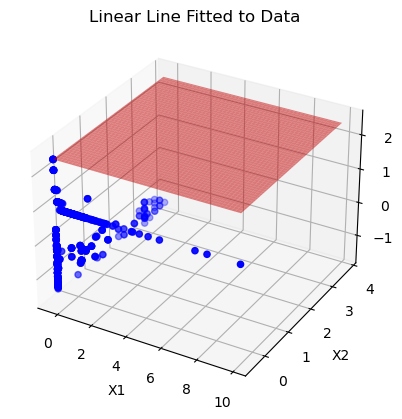

In [166]:
# Example usage:
# Assuming you have a DataFrame named 'df' with columns X1, X2, and X3
# and weights w1, w2, w3, and bias term
weights = np.array([w.data[0] for w in lr.w])
bias = lr.b.data[0]
plot_linear_line(X, weights, bias)

In [167]:
weights

array([-0.6107412 ,  0.70839827, -0.34378089,  0.63686599, -1.1630012 ,
        2.79426081, -0.12229451, -2.59744006,  1.20146282, -0.78421611,
       -1.9692451 ,  0.99863439, -3.68547598])